Importação das Bibliotecas

In [1]:
import os
import zipfile
import shutil
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import concurrent.futures
import matplotlib.pyplot as plt

import rasterio as rs
from skimage.transform import resize

Inicialização das Variáveis que seram utilizadas dirante a execução do código

In [2]:
IMG_HEIGHT = 64  # Definir a altura das imagens
IMG_WIDTH = 64   # Definir a largura das imagens
IMG_MASK_CHANNELS = 1  # Número de canais de imagem mascara
IMG_CHANNELS = 2  # Número de canais de imagem (bandas 11 e 12)
IMG_COLOR_CHANNELS = 3  # Número de canais de imagem coloridas
NUMERO_IMAGEN = 1
tamanho_recorte = IMG_HEIGHT


Diretório das Imagens e Saídas de .CSV e DataFrame

In [20]:
# Local onde as imagens seram salvas em seu computador
# path = "/home/cristiano/Imagens/"
path = "/home/emanoelcepr/Imagens/"

# # Treino Sentinel-2
origem =  path + "imagens_originais/Sentinel-2/treino/"
diretorio_imagens =  path + "imagens_originais/Sentinel-2/treino_processadas/"

# # Teste Sentinel-2
# origem = path + "imagens_originais/Sentinel-2/teste/"
# diretorio_imagens =  path + "imagens_originais/Sentinel-2/teste_processadas/"

# # Teste Landsat-8
# origem =  path + "imagens_originais/Landsat-8/teste/"
# diretorio_imagens =  path + "/imagens_originais/Landsat-8/teste_processadas/"

Extrair as imagens para o diretório onde seram processadas e adicionando um número para diferenciar as imagens de mesmo nome.

In [4]:
# Verifica se o diretório de destino existe, caso contrário, cria-o
if not os.path.exists(diretorio_imagens):
    os.makedirs(diretorio_imagens)

# Percorre todas as pastas compactadas no diretório de origem
for pasta_compactada in os.listdir(origem):
    caminho_pasta_compactada = os.path.join(origem, pasta_compactada)

    # Verifica se o item é uma pasta compactada
    if zipfile.is_zipfile(caminho_pasta_compactada):
        # Extrai o conteúdo do arquivo compactado para uma pasta temporária
        pasta_temporaria = os.path.join(diretorio_imagens, "temp")
        with zipfile.ZipFile(caminho_pasta_compactada, 'r') as zip_ref:
            zip_ref.extractall(pasta_temporaria)

        # Percorre todas as imagens na pasta temporária
        for nome_imagem in os.listdir(pasta_temporaria):
            caminho_imagem = os.path.join(pasta_temporaria, nome_imagem)

            # Verifica se o item é um arquivo de imagem
            if os.path.isfile(caminho_imagem):
                # Define o novo nome da imagem com o número no início
                novo_nome_imagem = f"{NUMERO_IMAGEN}_{nome_imagem}"

                # Move a imagem para o diretório de destino com o novo nome
                caminho_destino_imagem = os.path.join(diretorio_imagens, novo_nome_imagem)
                shutil.move(caminho_imagem, caminho_destino_imagem)

                # Incrementa o número para a próxima imagem
                NUMERO_IMAGEN += 1

        # Remove a pasta temporária após processar todas as imagens
        shutil.rmtree(pasta_temporaria)

print("Descompactação concluída.")

Descompactação concluída.


Neste ponte é realizado a criação das máscaras, tendo como base a Imagem de Banda12 e como Limiar o valor de 180. As máscaras criadas seram identificadas com o nome Mask e seus pixel seram normalizados para que o o Pixel de fundo tenha o valor 0 e a imagem o valor 1. 

In [5]:
from PIL import Image
import os
import concurrent.futures

def modificar_nome_arquivo(nome_arquivo):
    # Remover a sequência "_(Raw)"
    nome_arquivo_modificado = nome_arquivo.replace("B12(Raw)", " ")
    return nome_arquivo_modificado

def aplicar_limiar(imagem, limiar):
    # Converte a imagem para escala de cinza
    imagem_cinza = imagem.convert('L')

    # Binariza a imagem usando o limiar
    imagem_binarizada = imagem_cinza.point(lambda p: p > limiar and 255)

    return imagem_binarizada

def limiar_imagem(caminho_arquivo, output_dir):
    # Carrega a imagem
    imagem = Image.open(caminho_arquivo)

    # Aplicar o limiar de 180
    imagem_binarizada = aplicar_limiar(imagem, 180)

    # Obter o nome do arquivo sem a extensão
    nome_arquivo = os.path.basename(caminho_arquivo)
    nome_sem_extensao = os.path.splitext(nome_arquivo)[0]

    # Salvar a imagem binarizada com "_Mask" antes da extensão no diretório de saída
    nome_mask = nome_sem_extensao + "Mask.tiff"
    caminho_mask = os.path.join(output_dir, nome_mask)
    imagem_binarizada.save(caminho_mask)

def limiar_imagens(diretorio, output_dir):
    with concurrent.futures.ThreadPoolExecutor(max_workers=11) as executor:
        for nome_arquivo in os.listdir(diretorio):
            if nome_arquivo.endswith("B12_(Raw).tiff"):
                # Limpar o nome do arquivo
                nome_arquivo_limpo = modificar_nome_arquivo(nome_arquivo)

                # Obter o caminho completo do arquivo
                caminho_arquivo = os.path.join(diretorio, nome_arquivo)

                # Processar a imagem em um thread separado
                executor.submit(limiar_imagem, caminho_arquivo, output_dir)

# Utiliza processamento paralelo com max threads
with concurrent.futures.ThreadPoolExecutor(max_workers=11) as executor:
    futures = [executor.submit(limiar_imagens, diretorio_imagens, diretorio_imagens)]


In [6]:
# def modificar_nome_arquivo(nome_arquivo):
#     # Remover a sequência "_(Raw)"
#     nome_arquivo_modificado = nome_arquivo.replace("(Raw)", "")
#     return nome_arquivo_modificado

# def aplicar_limiar(imagem, limiar):
#     # Converte a imagem para escala de cinza
#     imagem_cinza = imagem.convert('L')

#     # Converte a imagem em escala de cinza para um array NumPy
#     imagem_np = np.array(imagem_cinza)

#     # Binariza a imagem usando o limiar
#     imagem_binarizada = np.where(imagem_np < limiar, 0, 1)

#     return imagem_binarizada

# def normalizar_imagem(imagem):
#     # Normalizar a imagem para que o valor de 0 seja preto (0) e o valor de 1 seja branco (1)
#     imagem_normalizada = imagem.astype(np.float32) / 255.0

#     return imagem_normalizada

# def limiar_imagens(diretorio, output_dir):
#     for nome_arquivo in os.listdir(diretorio):
#         if nome_arquivo.endswith("B12_(Raw).tiff") or nome_arquivo.endswith("B07_(Raw).tiff"):
#             # Limpar o nome do arquivo
#             nome_arquivo_limpo = modificar_nome_arquivo(nome_arquivo)

#             # Carrega a imagem
#             caminho_arquivo = os.path.join(diretorio, nome_arquivo)
#             imagem = Image.open(caminho_arquivo)

#             # Aplicar o limiar de 180
#             imagem_binarizada = aplicar_limiar(imagem, 180)

#             # Normalizar a imagem
#             imagem_normalizada = normalizar_imagem(imagem_binarizada)

#             # Obter o nome do arquivo sem a extensão
#             nome_sem_extensao = os.path.splitext(nome_arquivo_limpo)[0]

#             # Salvar a imagem binarizada com "_Mask" antes da extensão no diretório de saída
#             nome_mask = nome_sem_extensao + "Mask.tiff"
#             caminho_mask = os.path.join(output_dir, nome_mask)
#             imagem_mask = Image.fromarray((imagem_normalizada * 255).astype(bool))
#             imagem_mask.save(caminho_mask)

# # Utiliza processamento paralelo com max threads
# with concurrent.futures.ThreadPoolExecutor(max_workers=11) as executor:
#     futures = [executor.submit(limiar_imagens, diretorio_imagens, diretorio_imagens)]


Recorte das imagens em 64x64 
As imagens que possuem coordenadas geográficas precisam ser recortadas de tal forma que não percam esses dados. Já as máscaras não tem essa necessidade, pois não possiem essa caracteristica. 

In [7]:
import rasterio

def recortar_imagens(diretorio, tamanho_recorte):
    global numero_imagem
    
    # Percorre todas as imagens no diretório
    for nome_arquivo in os.listdir(diretorio):
        caminho_arquivo = os.path.join(diretorio, nome_arquivo)
        
        # Verifica se a imagem contém "B12_(Raw)", "B11_(Raw)" ou "Wildfires" no nome
        if "B12_(Raw)" in nome_arquivo or "B11_(Raw)" in nome_arquivo or "Wildfires" in nome_arquivo:
            # Carrega a imagem usando o rasterio para obter os metadados
            with rasterio.open(caminho_arquivo) as img:
                # Obtém as dimensões da imagem
                altura, largura = img.height, img.width
                
                # Obtém os metadados da imagem
                metadados = img.meta
            
            # Calcula o número de recortes horizontais e verticais
            num_recortes_horizontais = largura // tamanho_recorte
            num_recortes_verticais = altura // tamanho_recorte
            
            # Realiza o recorte e salva as imagens resultantes
            for i in range(num_recortes_horizontais):
                for j in range(num_recortes_verticais):
                    # Define as coordenadas do retângulo de recorte
                    esquerda = i * tamanho_recorte
                    superior = j * tamanho_recorte
                    direita = (i + 1) * tamanho_recorte
                    inferior = (j + 1) * tamanho_recorte
                    
                    # Carrega a imagem novamente para o recorte
                    with rasterio.open(caminho_arquivo) as img:
                        # Realiza o recorte usando a função read
                        recorte = img.read(window=((superior, inferior), (esquerda, direita)))
                        transform = rasterio.windows.transform(window=((superior, inferior), (esquerda, direita)), transform=img.transform)
                    
                    # Separa o nome do arquivo e a extensão
                    nome, extensao = os.path.splitext(nome_arquivo)
                    numero = nome_arquivo.split("_")[0]
                    nome = nome[nome.index('_'):]
                    
                    # Constrói o novo nome de arquivo com o prefixo desejado
                    novo_nome_arquivo = f"{str(numero).zfill(6)}{nome}_recorte_{i}_{j}{extensao}"
                    
                    # Salva o recorte em um novo arquivo com os mesmos metadados da imagem original
                    caminho_recorte = os.path.join(diretorio, novo_nome_arquivo)
                    with rasterio.open(caminho_recorte, 'w', **metadados) as dest:
                        dest.write(recorte)
                    
                    # Incrementa o número para a próxima imagem
                    numero_imagem += 1
                    
            # Remove a imagem original
            os.remove(caminho_arquivo)
        
        # Verifica se a imagem contém "Mask" no nome
        elif "Mask" in nome_arquivo:
            # Carrega a imagem
            imagem = cv2.imread(caminho_arquivo)
            
            # Obtém as dimensões da imagem
            altura, largura, _ = imagem.shape
            
            # Calcula o número de recortes horizontais e verticais
            num_recortes_horizontais = largura // tamanho_recorte
            num_recortes_verticais = altura // tamanho_recorte
            
            # Realiza o recorte e salva as imagens resultantes
            for i in range(num_recortes_horizontais):
                for j in range(num_recortes_verticais):
                    # Define as coordenadas do retângulo de recorte
                    esquerda = i * tamanho_recorte
                    superior = j * tamanho_recorte
                    direita = (i + 1) * tamanho_recorte
                    inferior = (j + 1) * tamanho_recorte
                    
                    # Realiza o recorte
                    recorte = imagem[superior:inferior, esquerda:direita]
                    
                    # Separa o nome do arquivo e a extensão
                    nome, extensao = os.path.splitext(nome_arquivo)
                    numero = nome_arquivo.split("_")[0]
                    nome = nome[nome.index('_'):]
                    
                    # Constrói o novo nome de arquivo com o prefixo desejado
                    novo_nome_arquivo = f"{str(numero).zfill(6)}{nome}_recorte_{i}_{j}{extensao}"
                    
                    # Salva o recorte em um novo arquivo
                    caminho_recorte = os.path.join(diretorio, novo_nome_arquivo)
                    cv2.imwrite(caminho_recorte, recorte)
                    
                    # Incrementa o número para a próxima imagem
                    numero_imagem += 1
                    
            # Remove a imagem original
            os.remove(caminho_arquivo)
            
    # Libera a memória das imagens
    cv2.destroyAllWindows()

numero_imagem = 0
recortar_imagens(diretorio_imagens, tamanho_recorte)


/home/emanoelcepr/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/home/emanoelcepr/.local/lib/python3.10/site-packages/rasterio/__init__.py:314: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


redimenciona as imagens em 64x64

In [8]:
import os
import cv2

def redimensionar_imagem(imagem, altura_desejada, largura_desejada):
    return cv2.resize(imagem, (largura_desejada, altura_desejada), interpolation=cv2.INTER_LINEAR)

def pad_imagem(imagem, altura_desejada, largura_desejada):
    altura_atual, largura_atual, _ = imagem.shape

    diferenca_altura = altura_desejada - altura_atual
    diferenca_largura = largura_desejada - largura_atual

    # Calcular quantos pixels devem ser adicionados em cada lado da imagem
    topo = diferenca_altura // 2
    base = diferenca_altura - topo
    esquerda = diferenca_largura // 2
    direita = diferenca_largura - esquerda

    # Preencher a imagem com bordas para atingir o tamanho desejado
    imagem_pad = cv2.copyMakeBorder(imagem, topo, base, esquerda, direita, cv2.BORDER_CONSTANT, value=(0, 0, 0))

    return imagem_pad

def redimensionar_imagens_no_diretorio(diretorio_imagens, altura_desejada, largura_desejada):
    for nome_arquivo in os.listdir(diretorio_imagens):
        caminho_arquivo = os.path.join(diretorio_imagens, nome_arquivo)

        # Verifica se o arquivo é uma imagem válida
        if not os.path.isfile(caminho_arquivo) or not nome_arquivo.lower().endswith(('.tiff')):
            continue

        # Carrega a imagem
        imagem = cv2.imread(caminho_arquivo)

        # Verifica se a imagem foi carregada corretamente
        if imagem is None:
            print(f"Erro ao carregar a imagem: {caminho_arquivo}")
            continue

        # Redimensiona a imagem para o tamanho desejado
        imagem_redimensionada = redimensionar_imagem(imagem, altura_desejada, largura_desejada)

        # Preenche a imagem com bordas se necessário para atingir o tamanho desejado
        imagem_pad = pad_imagem(imagem_redimensionada, altura_desejada, largura_desejada)

        # Salva a imagem redimensionada no mesmo caminho de origem
        cv2.imwrite(caminho_arquivo, imagem_pad)

# Defina a altura e largura desejadas para as imagens
altura_desejada = 64
largura_desejada = 64

# Redimensione todas as imagens no diretório
redimensionar_imagens_no_diretorio(diretorio_imagens, altura_desejada, largura_desejada)


É criado um dataframe para salvar ID_Imagem, Banda12, Linha, Coluna, Latitude e Longitude de cada imagem com o limiar maior ou igual a 180. Isso é feito para que seja possivel obter as coordenadas geográficas durante a visualização das imagens. 

In [21]:
def encontrar_coordenadas_primeiro_pixel_true(diretorio_imagens, limite_valor_pixel):
    # Lista para armazenar as informações de ID da imagem, nome do arquivo, linha, coluna, latitude e longitude do primeiro pixel true encontrado
    informacoes_primeiro_pixel_true = []

    # Iterar sobre os arquivos no diretório
    for arquivo in os.listdir(diretorio_imagens):
        
        if ("B12_(Raw)" in arquivo or "B07_(Raw)" in arquivo) and arquivo.endswith(".tiff"):
            caminho_arquivo = os.path.join(diretorio_imagens, arquivo)

            # Extrair o nome do arquivo e sua extensão usando os.path.basename
            nome_arquivo = os.path.basename(caminho_arquivo)

            # Extrair o ID da imagem do nome do arquivo (assumindo que o ID está antes do primeiro "_")
            id_imagem = nome_arquivo.split("_")[0]

            # Abrir a imagem usando o rasterio
            with rs.open(caminho_arquivo) as img:
                # Ler a matriz de pixels da imagem
                matriz_pixels = img.read(1)

                # Encontrar as posições de todos os pixels true
                indices_pixels_true = np.where(matriz_pixels >= limite_valor_pixel)
                if len(indices_pixels_true[0]) > 0:
                    # Pegar o primeiro pixel true encontrado
                    linha, coluna = indices_pixels_true[0][0], indices_pixels_true[1][0]

                    # Obter as coordenadas do primeiro pixel usando o transformador da imagem
                    transformador = img.transform
                    latitude, longitude = rs.transform.xy(transformador, linha, coluna)

                    # Adicionar as informações do primeiro pixel true à lista
                    informacoes_primeiro_pixel_true.append((id_imagem, nome_arquivo, linha, coluna, latitude, longitude))

    return informacoes_primeiro_pixel_true

# Valor limite do pixel para considerá-lo como "true"
limite_valor_pixel = 180

# Encontrar as coordenadas do primeiro pixel true nas imagens do diretório
lista_informacoes = encontrar_coordenadas_primeiro_pixel_true(diretorio_imagens, limite_valor_pixel)

# Criar um DataFrame a partir da lista de informações
df_metadados = pd.DataFrame(lista_informacoes, columns=["ID_Imagem", "Banda12", "Linha", "Coluna", "Latitude", "Longitude"])

# Ordenar o DataFrame pela coluna "ID_Imagem"
df_metadados.sort_values(by="ID_Imagem", inplace=True)

# Salvar o DataFrame em um arquivo CSV (ou outro formato de sua escolha)
destino_csv = os.path.join(diretorio_imagens, "metadados.csv")
df_metadados.to_csv(destino_csv, index=False)


In [18]:
# def encontrar_coordenadas_todos_pixels_true(diretorio_imagens, limite_valor_pixel):
#     # Lista para armazenar as informações de ID da imagem, nome do arquivo, linha, coluna, latitude e longitude de cada pixel true
#     informacoes_pixels_true = []

#     # Iterar sobre os arquivos no diretório
#     for arquivo in os.listdir(diretorio_imagens):
        
#         if ("B12_(Raw)" in arquivo or "B07_(Raw)" in arquivo) and arquivo.endswith(".tiff"):
#             caminho_arquivo = os.path.join(diretorio_imagens, arquivo)

#             # Extrair o nome do arquivo e sua extensão usando os.path.basename
#             nome_arquivo = os.path.basename(caminho_arquivo)

#             # Extrair o ID da imagem do nome do arquivo (assumindo que o ID está antes do primeiro "_")
#             id_imagem = nome_arquivo.split("_")[0]

#             # Abrir a imagem usando o rasterio
#             with rs.open(caminho_arquivo) as img:
#                 # Ler a matriz de pixels da imagem
#                 matriz_pixels = img.read(1)

#                 # Encontrar as posições de todos os pixels true
#                 indices_pixels_true = np.where(matriz_pixels >= limite_valor_pixel)
#                 if len(indices_pixels_true[0]) > 0:
#                     linhas, colunas = indices_pixels_true

#                     # Obter as coordenadas de todos os pixels usando o transformador da imagem
#                     transformador = img.transform
#                     latitudes, longitudes = rs.transform.xy(transformador, linhas, colunas)

#                     # Adicionar as informações de cada pixel true à lista
#                     for linha, coluna, latitude, longitude in zip(linhas, colunas, latitudes, longitudes):
#                         informacoes_pixels_true.append((id_imagem, nome_arquivo, linha, coluna, latitude, longitude))

#     return informacoes_pixels_true

# # Valor limite do pixel para considerá-lo como "true"
# limite_valor_pixel = 180

# # Encontrar as coordenadas de todos os pixels true nas imagens do diretório
# lista_informacoes = encontrar_coordenadas_todos_pixels_true(diretorio_imagens, limite_valor_pixel)

# # Criar um DataFrame a partir da lista de informações
# df_metadados = pd.DataFrame(lista_informacoes, columns=["ID_Imagem", "Banda12", "Linha", "Coluna", "Latitude", "Longitude"])

# # Ordenar o DataFrame pela coluna "ID_Imagem"
# df_metadados.sort_values(by="ID_Imagem", inplace=True)

# # Salvar o DataFrame em um arquivo CSV (ou outro formato de sua escolha)
# destino_csv = os.path.join(diretorio_imagens, "metadados.csv")
# df_metadados.to_csv(destino_csv, index= False )


In [10]:
# import os

# def contar_imagens(diretorio_imagens):
#     contador = 0
#     for nome_arquivo in os.listdir(diretorio_imagens):
#         caminho_arquivo = os.path.join(diretorio_imagens, nome_arquivo)

#         # Verifica se o arquivo é uma imagem válida
#         if not os.path.isfile(caminho_arquivo) or not nome_arquivo.lower().endswith(('.tiff')):
#             continue

#         # Verifica se o nome do arquivo contém a palavra "Mask"
#         if "Mask" in nome_arquivo:
#             contador += 1

#     return contador
# # Conta quantas imagens têm a palavra "Mask" em seu nome
# quantidade_imagens_com_mask = contar_imagens(diretorio_imagens)

# print(f"A quantidade de imagens com a palavra 'Mask' no nome é: {quantidade_imagens_com_mask}")


In [11]:
import os

def renomear_imagens(diretorio):
    for nome_arquivo in os.listdir(diretorio):
        caminho_arquivo_antigo = os.path.join(diretorio, nome_arquivo)

        # Verifica se o arquivo é uma imagem válida
        if not os.path.isfile(caminho_arquivo_antigo) or not nome_arquivo.lower().endswith(('.tiff')):
            continue

        # Verifica se o nome do arquivo contém "B12_(Raw)Mask"
        if "B12_(Raw)Mask" in nome_arquivo:
            # Constrói o novo nome de arquivo com a palavra "Mask"
            novo_nome_arquivo = nome_arquivo.replace("B12_(Raw)Mask", "Mask")

            # Renomeia o arquivo
            caminho_arquivo_novo = os.path.join(diretorio, novo_nome_arquivo)
            os.rename(caminho_arquivo_antigo, caminho_arquivo_novo)
            print(f"Imagem renomeada: {nome_arquivo} -> {novo_nome_arquivo}")

# Renomeia as imagens que contêm "B12_(Raw)Mask" no nome para "Mask"
renomear_imagens(diretorio_imagens)


Imagem renomeada: 000085_2022-08-01-00:00_2022-08-01-23:59_Sentinel-2_L2A_B12_(Raw)Mask_recorte_6_3.tiff -> 000085_2022-08-01-00:00_2022-08-01-23:59_Sentinel-2_L2A_Mask_recorte_6_3.tiff
Imagem renomeada: 000054_2021-09-18-00:00_2021-09-18-23:59_Sentinel-2_L2A_B12_(Raw)Mask_recorte_5_9.tiff -> 000054_2021-09-18-00:00_2021-09-18-23:59_Sentinel-2_L2A_Mask_recorte_5_9.tiff
Imagem renomeada: 000054_2021-09-18-00:00_2021-09-18-23:59_Sentinel-2_L2A_B12_(Raw)Mask_recorte_11_9.tiff -> 000054_2021-09-18-00:00_2021-09-18-23:59_Sentinel-2_L2A_Mask_recorte_11_9.tiff
Imagem renomeada: 000085_2022-08-01-00:00_2022-08-01-23:59_Sentinel-2_L2A_B12_(Raw)Mask_recorte_15_9.tiff -> 000085_2022-08-01-00:00_2022-08-01-23:59_Sentinel-2_L2A_Mask_recorte_15_9.tiff
Imagem renomeada: 000021_2021-09-06-00:00_2021-09-06-23:59_Sentinel-2_L2A_B12_(Raw)Mask_recorte_3_0.tiff -> 000021_2021-09-06-00:00_2021-09-06-23:59_Sentinel-2_L2A_Mask_recorte_3_0.tiff
Imagem renomeada: 000026_2023-06-17-00:00_2023-06-17-23:59_Sentine

Fit

In [12]:
# Função para redimensionar as imagens de entrada para o tamanho desejado
def redimensionar_imagem(imagem, altura_desejada, largura_desejada):
    return resize(imagem, (altura_desejada, largura_desejada), mode='constant', preserve_range=True)

# Obter número de imagens de treino
NUM_TRAIN_IMAGES = len([f for f in os.listdir(diretorio_imagens) if "Mask" in f])

# Obter listas de nomes de arquivo Sentinel-2
banda11_list = sorted([f for f in os.listdir(diretorio_imagens) if "B11_(Raw)" in f])
banda12_list = sorted([f for f in os.listdir(diretorio_imagens) if "B12_(Raw)" in f])
seg_list = sorted([f for f in os.listdir(diretorio_imagens) if "Mask" in f])
color_list = sorted([f for f in os.listdir(diretorio_imagens) if "Wildfires" in f])

with pd.option_context("display.max_columns", None):
    df = pd.DataFrame({'banda11': banda11_list, 'banda12': banda12_list, 'seg': seg_list, 'color': color_list})

# Obter listas de IDs
train_banda11_id_list = df['banda11'].tolist()
train_banda12_id_list = df['banda12'].tolist()
train_mask_id_list = df['seg'].tolist()
train_color_id_list = df['color'].tolist()

# criando as matrizes para armazenar as imagens 
# X_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
# Y_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_MASK_CHANNELS), dtype=bool)
# Z_train = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), dtype=np.float32)

X_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_MASK_CHANNELS), dtype=bool)
Z_test = np.zeros((NUM_TRAIN_IMAGES, IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), dtype=np.float32)

# Iterar sobre as listas usando enumerate
for i, (banda11_id, banda12_id, mask_id, color_id) in enumerate(zip(train_banda11_id_list, train_banda12_id_list, train_mask_id_list, train_color_id_list)):
    # Construir caminhos completos
    path_banda11 = os.path.join(diretorio_imagens, banda11_id)
    path_banda12 = os.path.join(diretorio_imagens, banda12_id)
    path_seg = os.path.join(diretorio_imagens, mask_id)
    path_color = os.path.join(diretorio_imagens, color_id)

    try:
        # Ler as imagens
        with rs.open(path_banda11) as img11, rs.open(path_banda12) as img12, rs.open(path_seg) as img_seg, rs.open(path_color) as img_color:
            banda11 = img11.read(1)
            banda12 = img12.read(1)
            seg = img_seg.read(1)
            color = img_color.read(1)

        # Juntar as bandas
        bandas = np.dstack((banda11, banda12))

        # Redimensionar as bandas para o tamanho desejado
        bandas_redimensionadas = redimensionar_imagem(bandas, IMG_HEIGHT, IMG_WIDTH)

        # Transformar bandas em valores entre 0 e 255
        bandas_redimensionadas = (bandas_redimensionadas / np.max(bandas_redimensionadas)) * 255

        # Inserir a imagem em X_train/X_test
        # X_train[i] = bandas_redimensionadas
        X_test[i] = bandas_redimensionadas

        # Redimensionar a máscara para a forma (IMG_HEIGHT, IMG_WIDTH, 1)
        mask = resize(seg, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)

        # Normalizar valores da máscara para True/False (ou 0/1)
        mask = mask.astype(bool)

        # Inserir a máscara em Y_train/Y_test
        # Y_train[i] = mask
        Y_test[i] = mask

        # Inserir a imagem em Z_train/Z_test
        # Z_train[i] = resize(color, (IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), mode='constant', preserve_range=True)
        Z_test[i] = resize(color, (IMG_HEIGHT, IMG_WIDTH, IMG_COLOR_CHANNELS), mode='constant', preserve_range=True)

    except (rs.errors.RasterioIOError, FileNotFoundError) as e:
        print(f"Erro ao abrir a imagem {banda11_id}: {e}")

# print('Shape do X_train:', X_train.shape)
# print('Shape do Y_train:', Y_train.shape)
# print('Shape do Z_train:', Z_train.shape)

print('Shape do X_test:', X_test.shape)
print('Shape do Y_test:', Y_test.shape)
print('Shape do Z_test:', Z_test.shape)


Shape do X_test: (1288, 64, 64, 2)
Shape do Y_test: (1288, 64, 64, 1)
Shape do Z_test: (1288, 64, 64, 3)


salva treino

In [13]:
# # Salvar X_train
# X_train_file = os.path.join(diretorio_imagens, 'X_train.npy')
# np.save(X_train_file, X_train)

# # Salvar Y_train
# Y_train_file = os.path.join(diretorio_imagens, 'Y_train.npy')
# np.save(Y_train_file, Y_train)

# # Salvar Y_train
# Z_train_file = os.path.join(diretorio_imagens, 'Z_train.npy')
# np.save(Z_train_file, Z_train)

Visualização de uma imagem a partir dos arquivos salvos.

In [14]:

# # Selecionar a primeira amostra da array X_test, que contém a imagem composta pelas duas bandas
# bandas = X_train[6]
# color = Z_train[6]
# mask = Y_train[6]

# # # Separar as bandas individuais (assumindo que as bandas estão na última dimensão)
# banda11 = bandas[:, :, 0]
# banda12 = bandas[:, :, 1]
# mask = mask[:, :, 0]

# # # Plotar as bandas individualmente
# plt.subplot(1, 4, 1)
# plt.imshow(banda11, cmap='gray')
# plt.title('Banda 11')

# plt.subplot(1, 4, 2)
# plt.imshow(banda12, cmap='gray')
# plt.title('Banda 12')

# plt.subplot(1, 4, 3)
# plt.imshow(mask, cmap='gray')
# plt.title('mask')

# plt.subplot(1, 4, 4)
# color_normalized = color / 255.0
# plt.imshow(color_normalized)
# plt.title('Color')


# plt.show()


Salva as entradas da Rede

In [15]:
# Salvar X_test
X_test_file = os.path.join(diretorio_imagens, 'X_test.npy')
np.save(X_test_file, X_test)

# Salvar Y_train
Y_test_file = os.path.join(diretorio_imagens, 'Y_test.npy')
np.save(Y_test_file, Y_test)

# Salvar Z_train
Z_test_file = os.path.join(diretorio_imagens, 'Z_test.npy')
np.save(Z_test_file, Z_test)

Visualização de uma imagem a partir dos arquivos salvos.

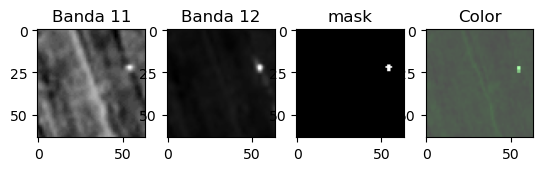

In [17]:

# Selecionar a primeira amostra da array X_test, que contém a imagem composta pelas duas bandas
bandas = X_test[15]
mask = Y_test[15]
color = Z_test[15]

# Separar as bandas individuais (assumindo que as bandas estão na última dimensão)
banda11 = bandas[:, :, 0]
banda12 = bandas[:, :, 1]

# Plotar as bandas individualmente
plt.subplot(1, 4, 1)
plt.imshow(banda11, cmap='gray')
plt.title('Banda 11')

plt.subplot(1, 4, 2)
plt.imshow(banda12, cmap='gray')
plt.title('Banda 12')

plt.subplot(1, 4, 3)
plt.imshow(mask, cmap='gray')
plt.title('mask')

plt.subplot(1, 4, 4)
color_normalized = color / 255.0
plt.imshow(color_normalized)
plt.title('Color')

plt.show()

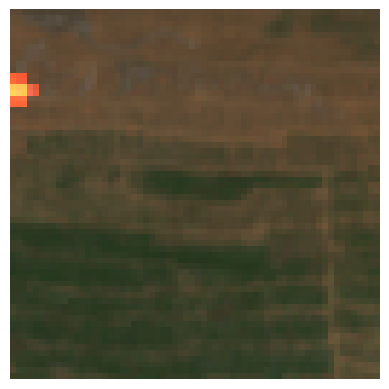

In [8]:
from PIL import Image
import os
import matplotlib.pyplot as plt

lista_imagens = []

# Listar todos os arquivos no diretório
arquivos = os.listdir(diretorio_imagens)

# Iterar sobre os arquivos e carregar as imagens .tiff no array
for arquivo in arquivos:
    if "Wildfires" in arquivo:
        caminho_arquivo = os.path.join(diretorio_imagens, arquivo)
        imagem = Image.open(caminho_arquivo)
        lista_imagens.append(imagem)

# Plotar a primeira imagem da lista
if lista_imagens:
    plt.imshow(lista_imagens[15])
    plt.axis('off')  # Opcional, para ocultar os eixos
    plt.show()
else:
    print("Nenhuma imagem .tiff contendo 'Wildfires' encontrada no diretório.")


In [11]:
from PIL import Image
import os

lista_imagens = []

# Listar todos os arquivos no diretório
arquivos = os.listdir(diretorio_imagens)

# Filtrar os arquivos para incluir somente os que contêm "Wildfires"
arquivos_filtrados = [arquivo for arquivo in arquivos if "B11_(Raw)" in arquivo]

# Ordenar os arquivos filtrados em ordem alfabética
arquivos_filtrados.sort()

# Iterar sobre os arquivos filtrados e carregar as imagens .tiff no array
for arquivo in arquivos_filtrados:
    caminho_arquivo = os.path.join(diretorio_imagens, arquivo)
    imagem = Image.open(caminho_arquivo)
    lista_imagens.append(imagem)

# Acessar a imagem específica do índice 56 na lista
imagem_especifica = lista_imagens[0]

# Agora você pode acessar os metadados da imagem diretamente usando o objeto imagem_especifica
print("Metadados da imagem TIFF:")
print(imagem_especifica.info)


Metadados da imagem TIFF:
{'compression': 'tiff_lzw', 'dpi': (1, 1), 'resolution': (1, 1)}


In [13]:
import rasterio

# Acessar a imagem específica do índice 0 na lista
imagem_especifica = lista_imagens[0]

# Abrir o arquivo TIFF com rasterio
dataset = rasterio.open(imagem_especifica.filename)

# Ler as coordenadas geográficas (latitude e longitude) do primeiro pixel
latitude, longitude = dataset.xy(0, 0)

# Fechar o dataset
dataset.close()

# Imprimir as coordenadas geográficas do primeiro pixel
print("Latitude do primeiro pixel:", latitude)
print("Longitude do primeiro pixel:", longitude)


Latitude do primeiro pixel: 0.5
Longitude do primeiro pixel: 0.5
